In [1]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
df = pd.read_csv('converted.csv')

In [3]:
df.head(2)

,Headline,Journalists,Date,Link,Summary,Article,__index_level_0__
0,"Hitachi, GE boost alliance in nuclear power bu...",[],"Mon Nov 13, 2006 3:16am EST",http://www.reuters.com/article/2006/11/13/us-e...,TOKYO - Hitachi Ltd. ( 6501.T ) said on Monda...,The move comes a month after France's Areva C...,0
1,"Volvo to cut 1,000 staff at Virginia plant",[],"Mon Nov 13, 2006 8:45am EST",http://www.reuters.com/article/2006/11/13/us-a...,STOCKHOLM - Truck maker Volvo said on Monday ...,After years of strong demand truck makers see...,1


# General Sentimental Analysis

In [4]:
sid = SentimentIntensityAnalyzer()

In [5]:
def get_sentiment(text):
    if isinstance(text, float):
        return sid.polarity_scores('')
    return sid.polarity_scores(text)

In [6]:
df['Scores'] = df['Article'].apply(get_sentiment)

In [7]:
df['Compound'] = df['Scores'].apply(lambda x: x['compound'])

In [8]:
df['Sentiment'] = df['Compound'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

In [9]:
df.head()

,Headline,Journalists,Date,Link,Summary,Article,__index_level_0__,Scores,Compound,Sentiment
0,"Hitachi, GE boost alliance in nuclear power bu...",[],"Mon Nov 13, 2006 3:16am EST",http://www.reuters.com/article/2006/11/13/us-e...,TOKYO - Hitachi Ltd. ( 6501.T ) said on Monda...,The move comes a month after France's Areva C...,0,"{'neg': 0.0, 'neu': 0.967, 'pos': 0.033, 'comp...",0.7184,positive
1,"Volvo to cut 1,000 staff at Virginia plant",[],"Mon Nov 13, 2006 8:45am EST",http://www.reuters.com/article/2006/11/13/us-a...,STOCKHOLM - Truck maker Volvo said on Monday ...,After years of strong demand truck makers see...,1,"{'neg': 0.056, 'neu': 0.903, 'pos': 0.04, 'com...",-0.2846,negative
2,European banks hiding full pension obligations,[Andrew Hurst],"Mon Nov 13, 2006 3:15am EST",http://www.reuters.com/article/2006/11/13/us-f...,"ZURICH, Nov 13 (Reuter) - West European banks...",Since adopting International Financial Report...,2,"{'neg': 0.065, 'neu': 0.889, 'pos': 0.046, 'co...",-0.6342,negative
3,"Hitachi, GE to form joint nuclear power ventures",[Mayumi Negishi],"Mon Nov 13, 2006 7:13am EST",http://www.reuters.com/article/2006/11/13/us-e...,TOKYO - Japan's Hitachi Ltd. and U.S. group G...,"The partnership would help Hitachi, Japan's b...",3,"{'neg': 0.036, 'neu': 0.884, 'pos': 0.08, 'com...",0.9497,positive
4,Eddie Bauer agrees to be bought for $286 million,[],"Mon Nov 13, 2006 7:29am EST",http://www.reuters.com/article/2006/11/13/us-r...,- Eddie Bauer Holdings Inc. EBHI.O said and i...,The cash deal is expected to provide Eddie Ba...,4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral


# General Classification model on the basis of sentiments

In [10]:
X = df['Article'].fillna('')
y = df['Sentiment']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [13]:
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [14]:
y_pred = model.predict(X_test_vectorized)

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7119400151860289
Classification Report:
              precision    recall  f1-score   support

    negative       0.55      0.73      0.63      6571
     neutral       0.68      0.11      0.20       566
    positive       0.83      0.73      0.78     13935

    accuracy                           0.71     21072
   macro avg       0.69      0.52      0.53     21072
weighted avg       0.74      0.71      0.71     21072



In [16]:
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative", "neutral"])

In [17]:
cm

array([[10153,  3762,    20],
       [ 1777,  4784,    10],
       [  321,   180,    65]])

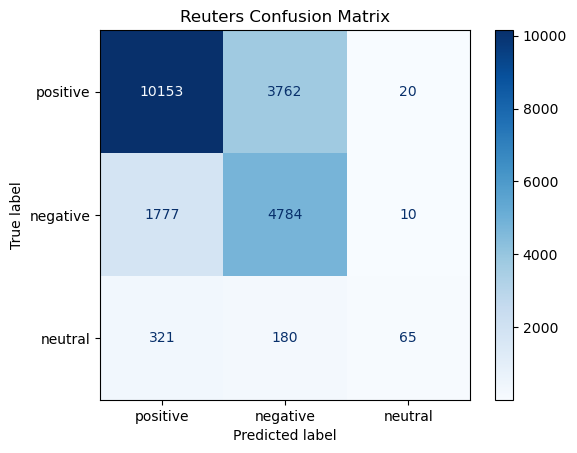

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["positive", "negative", "neutral"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Reuters Confusion Matrix")
plt.show()

In [19]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    return text

In [20]:
def predict_sentiment(new_texts):
    new_texts = [preprocess_text(text) for text in new_texts]
    new_texts_tfidf = vectorizer.transform(new_texts)
    predictions = model.predict(new_texts_tfidf)
    return predictions

In [21]:
new_texts = ["Great news for investors! $AAPL, $TSLA, and $AMZN stocks are on the rise, hitting new highs today. Bullish trends continue as market optimism grows. 📈🚀 #StockMarket #Investing #BullMarket"]

In [22]:
predictions = predict_sentiment(new_texts)

In [23]:
print(predictions)

['positive']


# Regression model on the basis of score value

In [24]:
def set_date(date_str):
    date_str_split = date_str.rsplit(' ', 1)
    date_part = date_str_split[0]
    timezone_part = date_str_split[1]
    date_obj = datetime.strptime(date_part, '%a %b %d, %Y %I:%M%p')
    timezone = pytz.timezone('US/Eastern')
    date_obj = timezone.localize(date_obj)
    formatted_date_time = date_obj.strftime('%Y-%m-%d')
    return formatted_date_time

In [25]:
df['Date'] = df['Date'].apply(set_date)

In [26]:
new_data = pd.DataFrame(df.groupby('Date').agg({'Compound':'mean'}).reset_index())

In [27]:
new_data['Date'] = pd.to_datetime(new_data['Date']).dt.date
new_data.Date=pd.to_datetime( new_data.Date,errors='coerce')

In [28]:
new_data['Months'] = new_data['Date'].dt.month
new_data['Years'] = new_data['Date'].dt.year

In [29]:
new_data['Date'] = pd.to_datetime(new_data['Years'].astype(str) + '-' + new_data['Months'].astype(str) + '-01', format='%Y-%m-%d')

In [30]:
new_data.drop(['Months', 'Years'], axis=1, inplace=True)

In [31]:
new_data_monthly = pd.DataFrame(new_data.groupby('Date').agg({'Compound':'mean'}).reset_index())

In [32]:
X = new_data_monthly.index.values.reshape(-1, 1)
y = new_data_monthly['Compound'].values.reshape(-1, 1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [35]:
y_pred = regressor.predict(X)

# Regression Line for the Monthly news for the Reuters

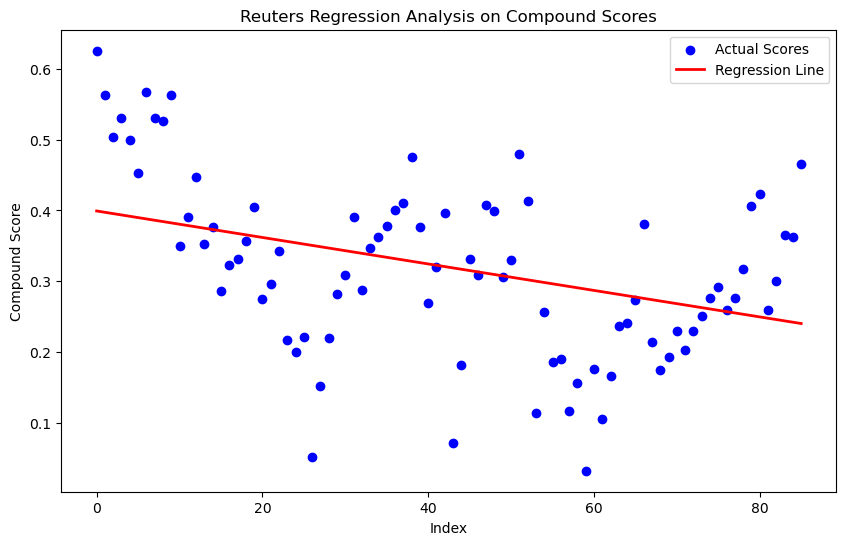

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Scores')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
plt.title('Reuters Regression Analysis on Compound Scores')
plt.xlabel('Index')
plt.ylabel('Compound Score')
plt.legend()
plt.show()